# 라이브러리 셋팅

- 참고자료 : https://www.kaggle.com/code/yerramvarun/pytorch-fasterrcnn-with-group-kfold-14-class

- Train : https://www.kaggle.com/code/pestipeti/vinbigdata-fasterrcnn-pytorch-inference/notebook

- Inference : https://www.kaggle.com/code/pestipeti/vinbigdata-fasterrcnn-pytorch-train/notebook



In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir yolo_labels
!kaggle datasets download -d awsaf49/vinbigdata-yolo-labels-dataset

In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset
# !kaggle datasets download -d awsaf49/vinbigdata-256-image-dataset

In [ ]:
!unzip -d /content/yolo_labels /content/vinbigdata-yolo-labels-dataset.zip

In [ ]:
# !unzip /content/vinbigdata-256-image-dataset.zip
!unzip /content/vinbigdata-512-image-dataset.zip

In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import json
import os

from sklearn.model_selection import GroupKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow


# 데이터셋 생성 (json-to-dataframe)

In [ ]:
templist = os.listdir('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/') # dataset-b
# templist = os.listdir('/content/content/YOLOV5_COCO_format/val2017') # dataset-d
newlist = []
for i in templist:
  id = i.split('.')[0]
  newlist.append(id+'_val.jpg')

In [ ]:
for i in templist:
  os.rename('/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/'+i, '/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/'+i.split('.')[0]+'_val.jpg') # dataset-b
#   os.rename('/content/content/YOLOV5_COCO_format/val2017/'+i, '/content/content/YOLOV5_COCO_format/val2017/'+i.split('.')[0]+'_val.jpg') # dataset-d

In [ ]:
%mv /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017/* /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/train2017/ # dataset-b
# %mv /content/content/YOLOV5_COCO_format/val2017/* /content/content/YOLOV5_COCO_format/train2017/ # dataset-d

!rm -r /content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017  # dataset-b
# !rm -r /content/content/YOLOV5_COCO_format/val2017 # dataset-d

In [ ]:
# annotations id리스트 생성 

train_animg_id = []
for i in range(len(train_json['annotations'])):
    for j,k in train_json['annotations'][i].items():
        # img_id_list.append(j['image_id'])
        if j == 'image_id':
            # print(k)
            train_animg_id.append(k)
            
val_animg_id = []
for i in range(len(val_json['annotations'])):
    for j,k in val_json['annotations'][i].items():
        # img_id_list.append(j['image_id'])
        if j == 'image_id':
            # print(k)
            val_animg_id.append(k)


# id:image_id 딕셔너리 생성 
train_img_id, val_img_id  = [],[]
train_img_filename, val_img_filename = [], []
for i in range(len(train_json['images'])):
    for j,k in train_json['images'][i].items():
        # print(j,k)
        if j == 'id':
            train_img_id.append(k)
        elif j == 'file_name':
            train_img_filename.append(k)
            

for i in range(len(val_json['images'])):
    for j,k in val_json['images'][i].items():
        # print(j,k)
        if j == 'id':
            val_img_id.append(k)
        elif j == 'file_name':
            name = k.split('.')[0] + '_val.jpg'
            val_img_filename.append(name)
            
train_img = { name:value for name, value in zip(train_img_id, train_img_filename) }
val_img = { name:value for name, value in zip(val_img_id, val_img_filename) }

In [ ]:
train_dic = {'image_id' : [], # = 'file_name'
             'class_id' : [], # = 'category_id'
             'image_path' : [], # file_name에 주소 추가해서 만들어주기 
             'xmin' : [],
             'ymin' : [],
             'xmax' : [],
             'ymax' : []}

val_dic = {  'image_id' : [], # = 'file_name'
             'class_id' : [], # = 'category_id'
             'image_path' : [], # file_name에 주소 추가해서 만들어주기 
             'xmin' : [],
             'ymin' : [],
             'xmax' : [],
             'ymax' : []}


# class_id, bbox 추가 
for i in range(len(train_json['annotations'])):
    for j,k in train_json['annotations'][i].items():
        if j == 'bbox':
            x_min = k[0]- k[2]/2
            if x_min < 0:
                x_min = 0
            y_min = k[1]- k[3]/2
            if y_min < 0:
                y_min = 0
            x_max = k[0]+ k[2]/2
            if x_max < 0:
                x_max = 0
            y_max = k[1]+ k[3]/2
            if y_max<0:
                y_max = 0

            train_dic['xmin'].append(x_min)
            train_dic['ymin'].append(y_min)
            train_dic['xmax'].append(x_max)
            train_dic['ymax'].append(y_max)
        
        elif j == 'category_id':
            train_dic['class_id'].append(k)
        
        # if j == 'image_id':
        #     # print(k)
        #     train_dic['image_id'].append(k)
        
for i in range(len(val_json['annotations'])):
    for j,k in val_json['annotations'][i].items():
        if j == 'bbox':
            x_min = k[0]- k[2]/2
            if x_min < 0:
                x_min = 0
            y_min = k[1]- k[3]/2
            if y_min < 0:
                y_min = 0
            x_max = k[0]+ k[2]/2
            if x_max < 0:
                x_max = 0
            y_max = k[1]+ k[3]/2
            if y_max<0:
                y_max = 0
            
            # min_max = [x_min, y_min, x_max, y_max]
            # val_dic['bbox'].append(min_max)
            
            val_dic['xmin'].append(x_min)
            val_dic['ymin'].append(y_min)
            val_dic['xmax'].append(x_max)
            val_dic['ymax'].append(y_max)

        elif j == 'category_id':
            val_dic['class_id'].append(k)



# image_id, image_path 추가 
train_dir = '/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/train2017/'


for i in train_animg_id:
    train_dic['image_id'].append(train_img.get(i))
    train_dic['image_path'].append(train_dir + train_img.get(i))   

for i in val_animg_id:
    val_dic['image_id'].append(val_img.get(i))
    val_dic['image_path'].append(train_dir + val_img.get(i))   

     


In [ ]:
train_df = pd.DataFrame(train_dic)
val_df = pd.DataFrame(val_dic)
train_df = pd.concat([train_df, val_df], axis=0).reset_index().drop('index', axis=1)
train_df

,image_id,class_id,image_path,xmin,ymin,xmax,ymax
0,000000000001.jpg,12,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,116.778616,34.730970,186.000000,62.000000
1,000000000001.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,214.095292,90.290528,298.000000,170.000000
2,000000000001.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,46.188259,248.680998,300.000000,320.000000
3,000000000001.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,52.481112,236.388145,300.000000,314.000000
4,000000000001.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,212.095292,88.290528,296.000000,168.000000
...,...,...,...,...,...,...,...
144379,000000005272_val.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,108.315079,60.905434,169.386347,300.145486
144380,000000005272_val.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,246.205551,241.430894,328.402101,315.481386
144381,000000005272_val.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,280.198050,246.141207,346.262566,315.152760
144382,000000005272_val.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,90.550638,58.166881,168.714179,301.131365


In [ ]:
# 바운딩박스 좌표에 음수 여부 검수용 
for i in range(len(train_json['annotations'])):
    for j,k in train_json['annotations'][i].items():
        if j == 'bbox':
            for box in k:
                if box < 0:
                    print('error')

# Faster R-CNN Train

In [ ]:
train_dir = '/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/train2017'
test_dir = '/content/content/YOLO2COCO/dataset/YOLOV5_COCO_format/val2017'

In [ ]:
class VBDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):

        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        # labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
        labels = torch.squeeze(torch.as_tensor((records.class_id.values,), dtype=torch.int64))
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
dt = VBDDataset(train_df, train_dir)
dt[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


(array([[[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.30980393, 0.30980393, 0.30980393],
         [0.32156864, 0.32156864, 0.32156

In [ ]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_id,image_path,xmin,ymin,xmax,ymax,fold
0,000000000001.jpg,12,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,116.778616,34.730970,186.0,62.0,4
1,000000000001.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,214.095292,90.290528,298.0,170.0,4
2,000000000001.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,46.188259,248.680998,300.0,320.0,4
3,000000000001.jpg,4,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,52.481112,236.388145,300.0,314.0,4
4,000000000001.jpg,1,/content/content/YOLO2COCO/dataset/YOLOV5_COCO...,212.095292,88.290528,296.0,168.0,4


In [ ]:
train_df.groupby('fold')['image_id'].agg(lambda x: x.nunique()).reset_index()

,fold,image_id
0,0,3515
1,1,3516
2,2,3515
3,3,3515
4,4,3515


In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
# A Class for keeping track of average
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(train_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(train_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


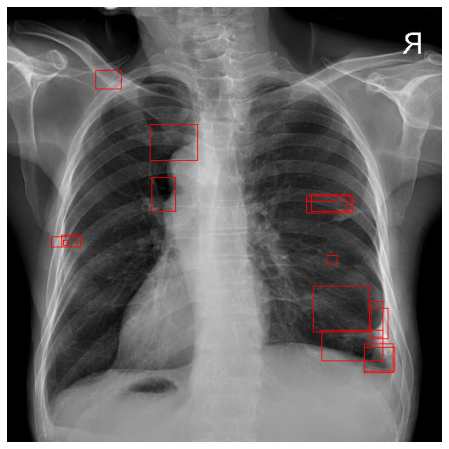

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())


    train_data_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader



def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1
        
        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses
        
        
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")


   

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(train_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)
    
    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)
    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [ ]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 5

# set folds
num_folds = 1

In [ ]:
for fold in range(num_folds):
    run_fold(fold)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

https://ndb796.tistory.com/509

In [ ]:
classes = []
for idx in train_json['categories']:
    classes.append(idx['name'])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


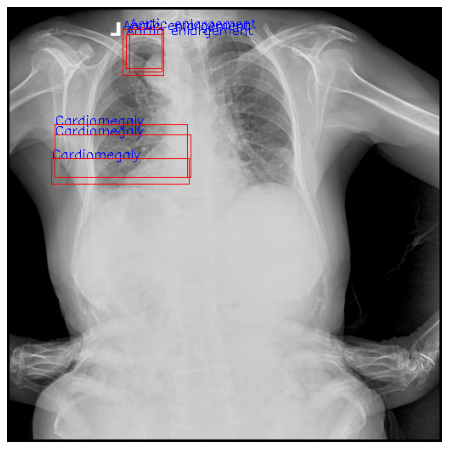

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
clss = targets[1]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

# Faster R-CNN Inference

In [ ]:
sample_submission_df = pd.read_csv('/content/vinbigdata/sample_submission.csv')
sample_submission_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1 0 0 1 1


In [ ]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
# !gdown https://drive.google.com/uc?id=1ok9pObM-ZkgKxGv0oNDGi0NCKCCsMAqr

In [ ]:
# !gdown https://drive.google.com/uc?id=1EryTzE4Oil1gpousxhGD_OE6HxPqef7Q

In [ ]:
# !gdown https://drive.google.com/uc?id=1-0R5AbR7pKm77ujaHFSsNeEGyV0cgXSt

Downloading...
From: https://drive.google.com/uc?id=1-0R5AbR7pKm77ujaHFSsNeEGyV0cgXSt
To: /content/fasterrcnn_model_Cdataset_epoch10.pt
100% 166M/166M [00:00<00:00, 196MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/dataset_B(20epoch)fasterrcnn_model_0.pt'))
# model.load_state_dict(torch.load('/content/fasterrcnn_model_bdataset_5epoch35.pt'))
# model.load_state_dict(torch.load('/content/fasterrcnn_model_Cdataset_epoch5.pt'))
# model.load_state_dict(torch.load('/content/fasterrcnn_model_Cdataset_epoch10.pt'))
model.eval()

x = model.to(device)

In [ ]:
train_dir = '/content/vinbigdata/train'
test_dir = '/content/vinbigdata/test'
train_df = pd.read_csv('/content/vinbigdata/train.csv')
test_df = pd.read_csv('/content/vinbigdata/test.csv')

In [ ]:
# wh_df

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, test_dir, get_test_transform())


test_data_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.4
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)

In [ ]:
results[0:2]

[{'PredictionString': '3 0.9455 172 198 397 290 10 0.7227 215 187 415 353',
  'image_id': '83caa8a85e03606cf57e49147d7ac569'},
 {'PredictionString': '0 0.9815 251 122 307 174 5 0.8702 55 83 203 385 5 0.6181 297 113 444 367 3 0.4013 159 259 379 359',
  'image_id': '7550347fa2bb96c2354a3716dfa3a69c'}]

In [ ]:
# 512x512 
pred_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
pred_df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 172 198 397 290 10 0.7227 215 187 415...
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 251 122 307 174 5 0.8702 55 83 203 38...
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 134 188 143 197 5 0.4345 60 129 228 388
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 162 351 389 408 0 0.8276 199 219 311 302
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 209 289 403 337 13 0.5455 376 161 420...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 270 130 317 176
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 284 161 344 236 3 0.6293 230 276 400 344
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 307 182 442 346 6 0.6013 131 112 219 ...
2998,04b700c4815f088728db9f093c739707,0 0.8912 264 178 326 233


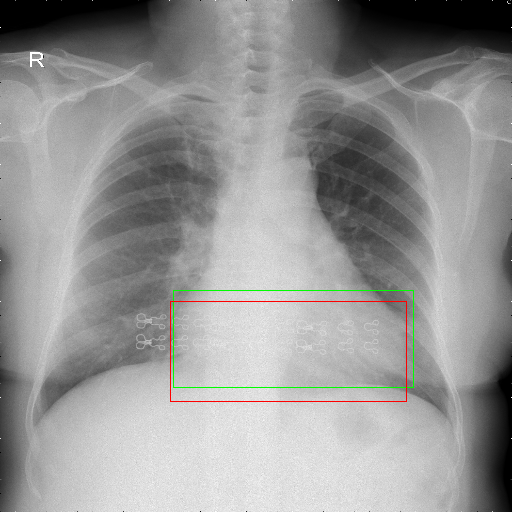

In [ ]:
# # 512x512 예측 바운딩 박스 시각화 - dataset_c_5epoch로 inference 시각화 
# img = cv2.imread('/content/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png')
# # cv2.rectangle(img, (x_min,y_min),	(x_max,y_max), 선 색, 선 굵기 )
# img = cv2.rectangle(img, (173,290), (413,387), (0,255,0),1) # 예측
# img = cv2.rectangle(img, (170,301),(406,401), (0,0,255),1) # 정답 
# cv2_imshow(img)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# for box in boxes:
#     cv2.rectangle(sample,
#                   (box[0], box[1]),
#                   (box[2], box[3]),
#                   (220, 0, 0), 2)
    
# ax.set_axis_off()
# ax.imshow(sample)

In [ ]:
pred_df.to_csv('submission_by_dataset_B(20epoch)fasterrcnn.csv', index=False)

# 제출 파일 원본 사이즈에 맞게 바꿔주기


현나`s 코드

In [ ]:
wh_df = pd.read_csv('/content/vinbigdata/test.csv')
wh_df

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,2642,3170
2996,c97e54a78bab9c05ce2e04fe6c284bcd,3072,3072
2997,33218cf183c1224a74ccfb514e827e15,2336,2836
2998,04b700c4815f088728db9f093c739707,2484,3064


In [ ]:
df = pd.read_csv('/content/submission_by_dataset_B(20epoch)fasterrcnn.csv')
df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 172 198 397 290 10 0.7227 215 187 415...
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 251 122 307 174 5 0.8702 55 83 203 38...
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 134 188 143 197 5 0.4345 60 129 228 388
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 162 351 389 408 0 0.8276 199 219 311 302
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 209 289 403 337 13 0.5455 376 161 420...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 270 130 317 176
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 284 161 344 236 3 0.6293 230 276 400 344
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 307 182 442 346 6 0.6013 131 112 219 ...
2998,04b700c4815f088728db9f093c739707,0 0.8912 264 178 326 233


In [ ]:
nofind_df = df[df['PredictionString'] == '14 1.0 0 0 1 1']
nofind_df

,image_id,PredictionString
16,cb3b210015a31adab114493e1150eaf8,14 1.0 0 0 1 1
18,564141a415cfa32841bb2de146faa5eb,14 1.0 0 0 1 1
24,5b6707d336c733e0a8d4233bb08483c7,14 1.0 0 0 1 1
33,415fe8e39c0546ff191f8e33888f09d4,14 1.0 0 0 1 1
40,7db8d2571612fa51c3fea231524803cc,14 1.0 0 0 1 1
...,...,...
2948,ff761085c11792ec5f439f6b74774550,14 1.0 0 0 1 1
2953,a2ea417d0e7d00cfd922fa93fc95b472,14 1.0 0 0 1 1
2954,eeb1c8fa0a8d21ecd33da05d335d4b18,14 1.0 0 0 1 1
2970,0919cca5a55ea3b156f45b5cd14fe8d3,14 1.0 0 0 1 1


In [ ]:
find_df = df[df['PredictionString'] != '14 1.0 0 0 1 1']
find_df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 172 198 397 290 10 0.7227 215 187 415...
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 251 122 307 174 5 0.8702 55 83 203 38...
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 134 188 143 197 5 0.4345 60 129 228 388
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 162 351 389 408 0 0.8276 199 219 311 302
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 209 289 403 337 13 0.5455 376 161 420...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 270 130 317 176
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 284 161 344 236 3 0.6293 230 276 400 344
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 307 182 442 346 6 0.6013 131 112 219 ...
2998,04b700c4815f088728db9f093c739707,0 0.8912 264 178 326 233


In [ ]:
temp_list = []
for i in find_df.image_id: #image_id 하나당
    w = int(wh_df[wh_df['image_id'] == i]['width'].values)
    h = int(wh_df[wh_df['image_id'] == i]['height'].values)
    temp = find_df[find_df['image_id']==i]['PredictionString'].values[0].split(' ') #prediction string값 들어감
    temp_len = len(temp) #prediction string속 data 개수
    for j in range(temp_len):
        if j % 6 == 2: #xmin
            temp[j] = int(temp[j]) / 512 * w
        elif j % 6 == 3: #ymin
            temp[j] = int(temp[j]) / 512 * h
        elif j % 6 == 4: #xmax
            temp[j] = int(temp[j]) / 512 * w
        elif j % 6 == 5: #ymax
            temp[j] = int(temp[j]) / 512 * h
    #print(temp) -> ['3', '0.6246', 306.865234375, 918.53125, 1305.322265625, 1463.59375]
    temp_list.append(temp)
find_df['new_prediction'] = temp_list  #이제 이 temp값을 prediction string에 넣어주는 작업
find_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,image_id,PredictionString,new_prediction
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 172 198 397 290 10 0.7227 215 187 415...,"[3, 0.9455, 774.0, 1113.75, 1786.5, 1631.25, 1..."
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 251 122 307 174 5 0.8702 55 83 203 38...,"[0, 0.9815, 1244.21484375, 737.48046875, 1521...."
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 134 188 143 197 5 0.4345 60 129 228 388,"[8, 0.7649, 729.671875, 1145.625, 778.6796875,..."
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 162 351 389 408 0 0.8276 199 219 311 302,"[3, 0.9901, 630.9140625, 1665.87890625, 1514.9..."
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 209 289 403 337 13 0.5455 376 161 420...,"[3, 0.9292, 839.265625, 1341.140625, 1618.2968..."
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 270 130 317 176,"[0, 0.7949, 1393.2421875, 804.8828125, 1635.76..."
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 284 161 344 236 3 0.6293 230 276 400 344,"[0, 0.9491, 1704.0, 966.0, 2064.0, 1416.0, 3, ..."
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 307 182 442 346 6 0.6013 131 112 219 ...,"[9, 0.7883, 1400.6875, 1008.109375, 2016.625, ..."
2998,04b700c4815f088728db9f093c739707,0 0.8912 264 178 326 233,"[0, 0.8912, 1280.8125, 1065.21875, 1581.609375..."


In [ ]:
lists = []
for i in find_df['new_prediction']:
    result = ''
    for j in i:
        result += str(j) + ' '
    lists.append(result)
print(len(lists))

2536


In [ ]:
find_df['PredictionString'] = lists
find_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_id,PredictionString,new_prediction
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 774.0 1113.75 1786.5 1631.25 10 0.722...,"[3, 0.9455, 774.0, 1113.75, 1786.5, 1631.25, 1..."
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 1244.21484375 737.48046875 1521.80859...,"[0, 0.9815, 1244.21484375, 737.48046875, 1521...."
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 729.671875 1145.625 778.6796875 1200....,"[8, 0.7649, 729.671875, 1145.625, 778.6796875,..."
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 630.9140625 1665.87890625 1514.972656...,"[3, 0.9901, 630.9140625, 1665.87890625, 1514.9..."
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 839.265625 1341.140625 1618.296875 15...,"[3, 0.9292, 839.265625, 1341.140625, 1618.2968..."
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 1393.2421875 804.8828125 1635.7695312...,"[0, 0.7949, 1393.2421875, 804.8828125, 1635.76..."
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 1704.0 966.0 2064.0 1416.0 3 0.6293 1...,"[0, 0.9491, 1704.0, 966.0, 2064.0, 1416.0, 3, ..."
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 1400.6875 1008.109375 2016.625 1916.5...,"[9, 0.7883, 1400.6875, 1008.109375, 2016.625, ..."
2998,04b700c4815f088728db9f093c739707,0 0.8912 1280.8125 1065.21875 1581.609375 1394...,"[0, 0.8912, 1280.8125, 1065.21875, 1581.609375..."


In [ ]:
find_df['PredictionString'] = find_df['PredictionString'].str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
find_df = find_df.drop('new_prediction', axis=1)
find_df

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.9455 774.0 1113.75 1786.5 1631.25 10 0.722...
1,7550347fa2bb96c2354a3716dfa3a69c,0 0.9815 1244.21484375 737.48046875 1521.80859...
2,74b23792db329cff5843e36efb8aa65a,8 0.7649 729.671875 1145.625 778.6796875 1200....
3,94568a546be103177cb582d3e91cd2d8,3 0.9901 630.9140625 1665.87890625 1514.972656...
4,6da36354fc904b63bc03eb3884e0c35c,3 0.9292 839.265625 1341.140625 1618.296875 15...
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 1393.2421875 804.8828125 1635.7695312...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 1704.0 966.0 2064.0 1416.0 3 0.6293 1...
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 1400.6875 1008.109375 2016.625 1916.5...
2998,04b700c4815f088728db9f093c739707,0 0.8912 1280.8125 1065.21875 1581.609375 1394...


In [ ]:
find_df['PredictionString'][0]

'3 0.9455 774.0 1113.75 1786.5 1631.25 10 0.7227 967.5 1051.875 1867.5 1985.625'

In [ ]:
submit_df = pd.concat([nofind_df, find_df], axis=0, ignore_index=True)
submit_df


,image_id,PredictionString
0,cb3b210015a31adab114493e1150eaf8,14 1.0 0 0 1 1
1,564141a415cfa32841bb2de146faa5eb,14 1.0 0 0 1 1
2,5b6707d336c733e0a8d4233bb08483c7,14 1.0 0 0 1 1
3,415fe8e39c0546ff191f8e33888f09d4,14 1.0 0 0 1 1
4,7db8d2571612fa51c3fea231524803cc,14 1.0 0 0 1 1
...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,0 0.7949 1393.2421875 804.8828125 1635.7695312...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.9491 1704.0 966.0 2064.0 1416.0 3 0.6293 1...
2997,33218cf183c1224a74ccfb514e827e15,9 0.7883 1400.6875 1008.109375 2016.625 1916.5...
2998,04b700c4815f088728db9f093c739707,0 0.8912 1280.8125 1065.21875 1581.609375 1394...


In [ ]:
submit_df.to_csv('submit_df.csv', index=False)